In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import warnings 
warnings.filterwarnings("ignore")



/home/guts/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Load the data

path = "/home/guts/Documents/accel_data/acceleration_data.csv"
data = pd.read_csv(path)
data

,Timestamp,Acceleration
0,2024-08-09 14:23:41,10.110164
1,2024-08-09 14:23:42,9.555678
2,2024-08-09 14:23:44,9.325334
3,2024-08-09 14:23:48,9.532025
4,2024-08-09 14:23:49,9.468498
...,...,...
18662,2024-08-10 01:05:10,9.490646
18663,2024-08-10 01:05:13,10.447052
18664,2024-08-10 01:05:15,9.073947
18665,2024-08-10 01:05:16,10.054511


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

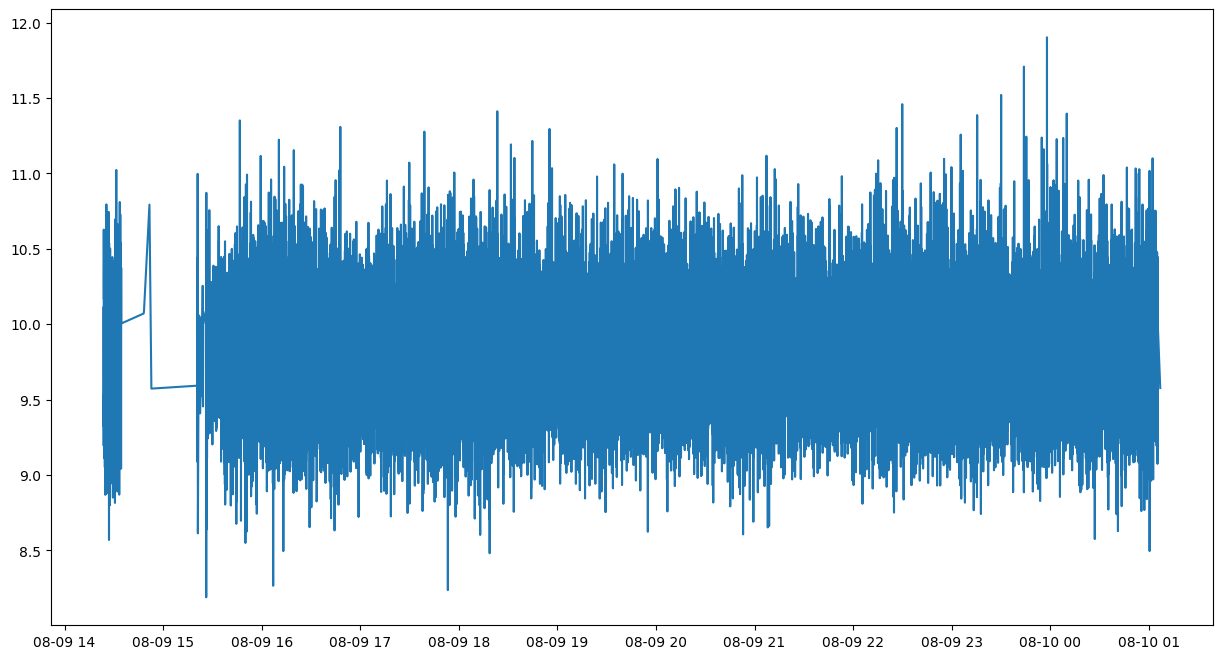

In [4]:
# Preprocess the data

data['Timestamp'] = pd.to_datetime(data['Timestamp'])
plt.figure(figsize=(15, 8))
plt.plot(data['Timestamp'], data['Acceleration'])

In [5]:
from copy import deepcopy as copy


# Create the dataset with lookback 
def create_dataset(data, n_steps):
    data = copy(data)

    data.set_index('Timestamp', inplace=True)

    for i in range(1, n_steps+1): # Create columns for each lag
        data[f'Acceleration_(t-{i})'] = data['Acceleration'].shift(i) # Shift the data by i steps

    data.dropna(inplace=True)
    return data

lookback = 10
shifted_data = create_dataset(data, lookback)
shifted_data

,Acceleration,Acceleration_(t-1),Acceleration_(t-2),Acceleration_(t-3),Acceleration_(t-4),Acceleration_(t-5),Acceleration_(t-6),Acceleration_(t-7),Acceleration_(t-8),Acceleration_(t-9),Acceleration_(t-10)
Timestamp,,,,,,,,,,,
2024-08-09 14:23:58,10.166208,10.291631,10.394547,10.627051,10.122995,9.194019,9.468498,9.532025,9.325334,9.555678,10.110164
2024-08-09 14:24:00,10.200596,10.166208,10.291631,10.394547,10.627051,10.122995,9.194019,9.468498,9.532025,9.325334,9.555678
2024-08-09 14:24:05,10.561841,10.200596,10.166208,10.291631,10.394547,10.627051,10.122995,9.194019,9.468498,9.532025,9.325334
2024-08-09 14:24:07,10.132648,10.561841,10.200596,10.166208,10.291631,10.394547,10.627051,10.122995,9.194019,9.468498,9.532025
2024-08-09 14:24:08,10.430693,10.132648,10.561841,10.200596,10.166208,10.291631,10.394547,10.627051,10.122995,9.194019,9.468498
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-10 01:05:10,9.490646,9.253248,9.599281,10.029815,9.321137,10.179704,9.540978,10.476114,10.422414,10.152716,10.116844
2024-08-10 01:05:13,10.447052,9.490646,9.253248,9.599281,10.029815,9.321137,10.179704,9.540978,10.476114,10.422414,10.152716
2024-08-10 01:05:15,9.073947,10.447052,9.490646,9.253248,9.599281,10.029815,9.321137,10.179704,9.540978,10.476114,10.422414


In [6]:
shifted_data_as_np = shifted_data.to_numpy()
shifted_data_as_np

array([[10.16620821, 10.29163067, 10.39454704, ...,  9.32533385,
         9.5556775 , 10.11016373],
       [10.20059577, 10.16620821, 10.29163067, ...,  9.53202479,
         9.32533385,  9.5556775 ],
       [10.56184063, 10.20059577, 10.16620821, ...,  9.46849785,
         9.53202479,  9.32533385],
       ...,
       [ 9.07394654, 10.44705204,  9.49064588, ...,  9.54097846,
        10.47611374, 10.42241404],
       [10.05451137,  9.07394654, 10.44705204, ..., 10.17970351,
         9.54097846, 10.47611374],
       [ 9.57648913, 10.05451137,  9.07394654, ...,  9.32113694,
        10.17970351,  9.54097846]])

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_data_as_np = scaler.fit_transform(shifted_data_as_np)

shifted_data_as_np

array([[ 0.06483615,  0.13236869,  0.18778304, ..., -0.38792475,
        -0.26389837,  0.03465952],
       [ 0.0833518 ,  0.06483615,  0.13236869, ..., -0.27663395,
        -0.38792475, -0.26389837],
       [ 0.2778607 ,  0.0833518 ,  0.06483615, ..., -0.31083943,
        -0.27663395, -0.38792475],
       ...,
       [-0.52328188,  0.21605386, -0.29891403, ..., -0.27181293,
         0.23170186,  0.20278776],
       [ 0.00469403, -0.52328188,  0.21605386, ...,  0.07210256,
        -0.27181293,  0.23170186],
       [-0.25269254,  0.00469403, -0.52328188, ..., -0.39018453,
         0.07210256, -0.27181293]])

In [8]:
X = shifted_data_as_np[:, 1:]
y = shifted_data_as_np[:, 0]

X.shape, y.shape   

((18657, 10), (18657,))

In [9]:
X = copy(np.flip(X, axis=1)) # Reverse the order of the columns
X

array([[ 0.03465952, -0.26389837, -0.38792475, ...,  0.3129726 ,
         0.18778304,  0.13236869],
       [-0.26389837, -0.38792475, -0.27663395, ...,  0.18778304,
         0.13236869,  0.06483615],
       [-0.38792475, -0.27663395, -0.31083943, ...,  0.13236869,
         0.06483615,  0.0833518 ],
       ...,
       [ 0.20278776,  0.23170186, -0.27181293, ..., -0.42673878,
        -0.29891403,  0.21605386],
       [ 0.23170186, -0.27181293,  0.07210256, ..., -0.29891403,
         0.21605386, -0.52328188],
       [-0.27181293,  0.07210256, -0.39018453, ...,  0.21605386,
        -0.52328188,  0.00469403]])

In [11]:
split_index = int(0.95 * len(X)) # 95% of the data will be used for training
split_index

17724

In [12]:
# Split the data into training and testing sets

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((17724, 10), (17724,), (933, 10), (933,))

In [13]:
# Convert the data to PyTorch tensors

X_train = X_train.reshape(-1, lookback, 1)
X_test = X_test.reshape(-1, lookback, 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((17724, 10, 1), (17724, 1), (933, 10, 1), (933, 1))

In [14]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([17724, 10, 1]),
 torch.Size([17724, 1]),
 torch.Size([933, 10, 1]),
 torch.Size([933, 1]))

In [15]:
from torch.utils.data import Dataset

# Create a custom dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)


In [16]:
from torch.utils.data import DataLoader
# Create the data loaders

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:


for _, batch in enumerate(train_loader): # Loop through the training data
    X_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([16, 10, 1]) torch.Size([16, 1])


In [18]:
class LSTM(nn.Module): # Define the LSTM model
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(input_size=1, hidden_size=4, num_layers=2).to(device)
model

LSTM(
  (lstm): LSTM(1, 4, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [19]:
def train_one_epoch(): # Train the model for one epoch
    model.train(True)
    print(f'Epoch {epoch+1}')
    train_loss = 0.0

    for i, batch in enumerate(train_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 99: # Print the loss every 100 batches
            avg_loss = train_loss / 100
            print(f'Batch {i}, Loss {loss.item()}')

            train_loss = 0.0

    print()

In [20]:

def validate_one_epoch(): # Validate the model for one epoch
    model.train(False)
    val_loss = 0.0

    for i, batch in enumerate(test_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader) # Calculate the average validation loss
    print(f'Validation Loss {avg_val_loss}')
    print()

In [21]:
# Train the model

learning_rate = 0.001
num_epochs = 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch 1
Batch 99, Loss 0.07666987180709839
Batch 199, Loss 0.0760161429643631
Batch 299, Loss 0.056002430617809296
Batch 399, Loss 0.06825318932533264
Batch 499, Loss 0.04810331016778946
Batch 599, Loss 0.0755232498049736
Batch 699, Loss 0.08385203778743744
Batch 799, Loss 0.041462648659944534
Batch 899, Loss 0.04599739983677864
Batch 999, Loss 0.0848451778292656
Batch 1099, Loss 0.03741562366485596

Validation Loss 0.001199121318631253

Epoch 2
Batch 99, Loss 0.07036562263965607
Batch 199, Loss 0.046673621982336044
Batch 299, Loss 0.12200134992599487
Batch 399, Loss 0.06538291275501251
Batch 499, Loss 0.0437890887260437
Batch 599, Loss 0.05160921812057495
Batch 699, Loss 0.05971328541636467
Batch 799, Loss 0.03593473881483078
Batch 899, Loss 0.07787981629371643
Batch 999, Loss 0.05386984348297119
Batch 1099, Loss 0.06287427991628647

Validation Loss 0.0012764399081973707

Epoch 3
Batch 99, Loss 0.060227081179618835
Batch 199, Loss 0.059764593839645386
Batch 299, Loss 0.059297107160091

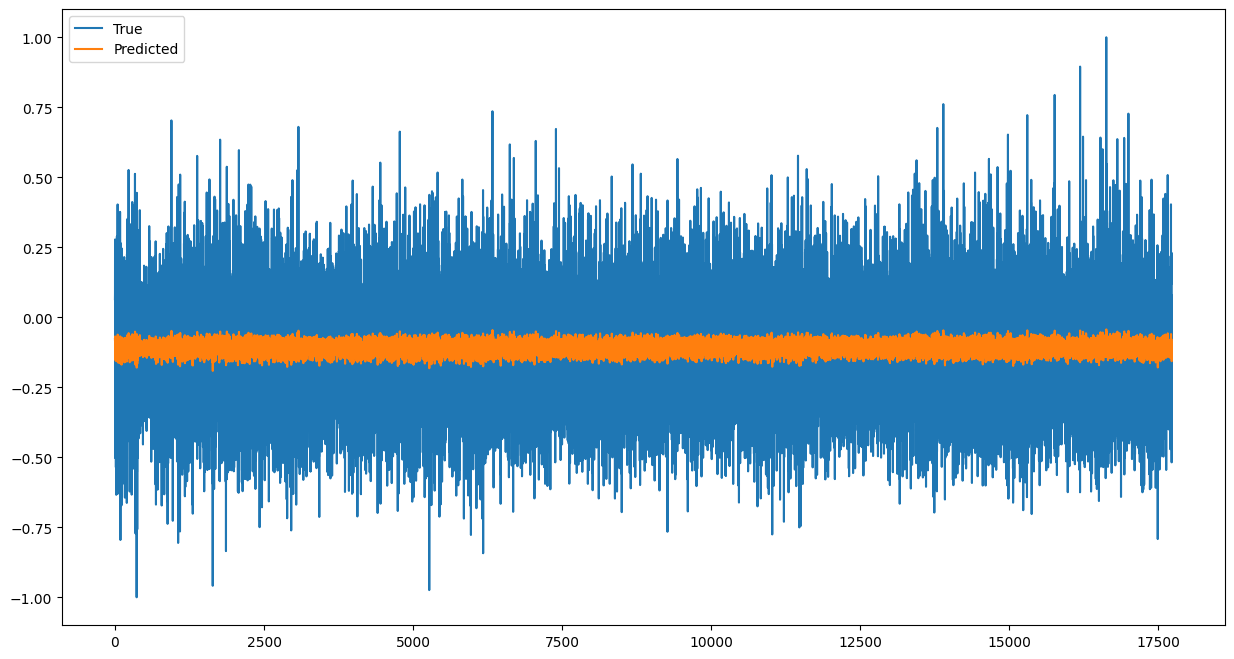

In [22]:
# Make predictions

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.figure(figsize=(15, 8))
plt.plot(y_train.cpu().numpy(), label='True')
plt.plot(predicted, label='Predicted')
plt.legend()

In [23]:
# Inverse transform the data

train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0]= train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = copy(dummies[:,0])
train_predictions

array([9.90150743, 9.88912291, 9.89044374, ..., 9.77154902, 9.75447813,
       9.89595681])

In [24]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0]= y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = copy(dummies[:,0])
new_y_train

array([10.16620821, 10.20059576, 10.56184063, ...,  9.08343519,
       10.47247727, 10.27184978])

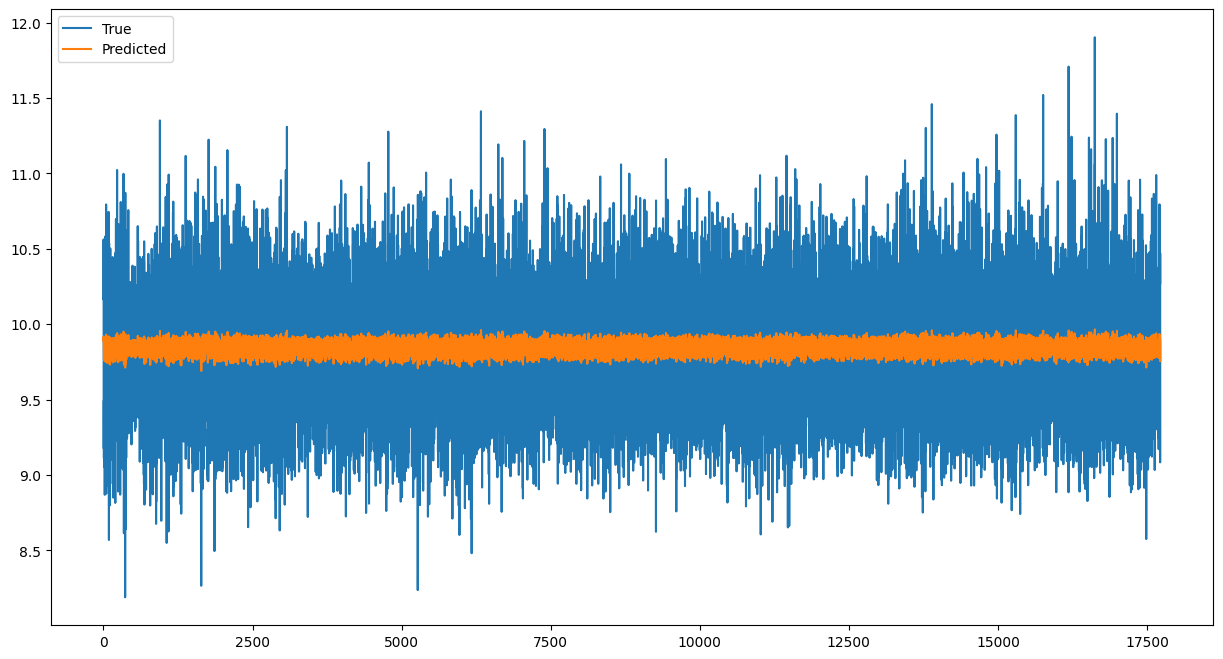

In [25]:
# Plot the predictions

plt.figure(figsize=(15, 8))
plt.plot(new_y_train, label='True')
plt.plot(train_predictions, label='Predicted')
plt.legend()


In [26]:
# Make predictions on the test set

test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0]= test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = copy(dummies[:,0])
test_predictions

array([9.89271631, 9.91916586, 9.89635765, 9.8799344 , 9.87369977,
       9.82437356, 9.88929723, 9.8861889 , 9.82584203, 9.90440697,
       9.80749093, 9.75455025, 9.7831271 , 9.80417949, 9.85702999,
       9.88573352, 9.79152855, 9.88993113, 9.80033413, 9.73262284,
       9.84771522, 9.81310031, 9.77038339, 9.77500362, 9.85244452,
       9.87089499, 9.81286593, 9.79986706, 9.80010155, 9.74980305,
       9.79835805, 9.78142021, 9.85574774, 9.76488593, 9.79329856,
       9.86094936, 9.86768162, 9.82285823, 9.8129458 , 9.86049747,
       9.8711303 , 9.90336298, 9.81697617, 9.87121588, 9.77824991,
       9.85877045, 9.77013044, 9.87231793, 9.79213055, 9.79493361,
       9.8749919 , 9.89389792, 9.89156243, 9.78931745, 9.7710449 ,
       9.79128886, 9.79839101, 9.76372902, 9.76776783, 9.87345285,
       9.7922177 , 9.87730251, 9.90226871, 9.87942269, 9.80591544,
       9.88684069, 9.88922651, 9.81960153, 9.88407585, 9.82389047,
       9.81502367, 9.80916223, 9.87072009, 9.78077844, 9.89210

In [27]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0]= y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = copy(dummies[:,0])
new_y_test

array([10.5525332 , 10.21450329, 10.06920381, 10.03642804,  9.56375518,
       10.27140823, 10.16587887,  9.5429973 , 10.44147802,  9.33357627,
        8.98313347,  9.38858702,  9.57884329, 10.03003468, 10.24310046,
        9.25613587, 10.31387378,  9.34065363,  8.7708572 , 10.00246828,
        9.57718558,  9.18773501,  9.31214839, 10.02867861, 10.11631755,
        9.50697004,  9.46295006,  9.49711459,  9.00840033,  9.56396739,
        9.36546944, 10.04586678,  9.08685124,  9.48345737, 10.08922604,
       10.06530079,  9.59972383,  9.56389344, 10.02058925, 10.07237624,
       10.3917888 ,  9.43347776, 10.08121614,  9.13347397, 10.01353068,
        9.09785236, 10.16226996,  9.3045688 ,  9.43616813, 10.19466476,
       10.3053046 , 10.21904253,  9.18416332,  9.19464123,  9.45207718,
        9.50974852,  9.16829495,  9.26535414, 10.24473513,  9.34393197,
       10.20377374, 10.40488041, 10.0747095 ,  9.38033915, 10.26367722,
       10.21543125,  9.48005582, 10.21376573,  9.55510629,  9.55

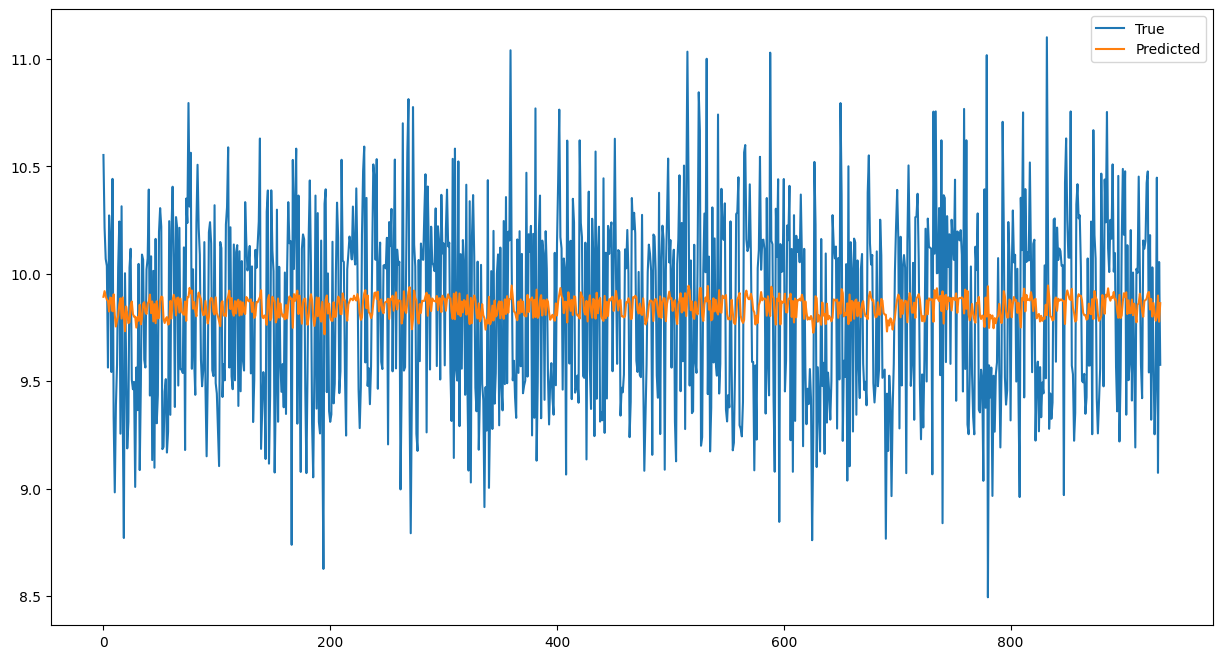

In [28]:
plt.figure(figsize=(15, 8))
plt.plot(new_y_test, label='True')
plt.plot(test_predictions, label='Predicted')
plt.legend()
